# Neural Machine Translation with Attention mechanism

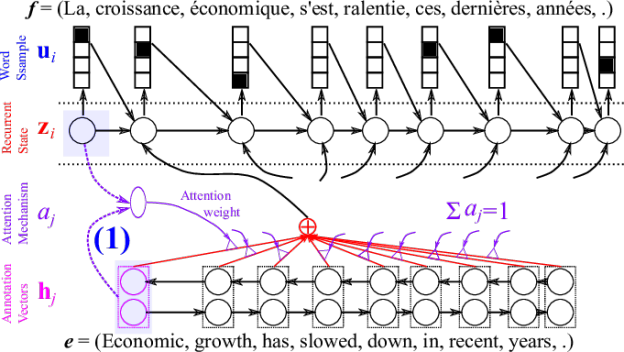

### What is Attention?

Attention is an interface between the encoder and decoder that provides the decoder with information from every encoder hidden state. With this setting, the model is able to selectively focus on useful parts of the input sequence and hence, learn the alignment between them. This helps the model to cope effectively with long input sentences .

In [ ]:
!pip install chart-studio

In [1]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf

#tf.enable_eager_execution()

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import time
import string

import chart_studio.plotly
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
plotly.offline.init_notebook_mode(connected=True)
import plotly.graph_objs as go

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/englishportuguese-translation/por.txt


### As in case of any NLP task, after reading the input file, we perform the basic cleaning and preprocessing as follows:

In [2]:
file_path = '../input/englishportuguese-translation/por.txt' # please set the path according to your system

In [3]:
lines = open(file_path, encoding='UTF-8').read().strip().split('\n')
lines[5000:5010]

['Will it rain?\tSerá que chove?\tCC-BY 2.0 (France) Attribution: tatoeba.org #8918600 (CK) & #8930552 (JGEN)',
 'Wish me luck.\tDeseje-me sorte.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2254917 (CK) & #872788 (alexmarcelo)',
 "Won't you go?\tVocê não vai?\tCC-BY 2.0 (France) Attribution: tatoeba.org #241051 (CK) & #6212788 (bill)",
 'Write in ink.\tEscreva à tinta.\tCC-BY 2.0 (France) Attribution: tatoeba.org #3258764 (CM) & #7351595 (alexmarcelo)',
 'Write in ink.\tEscreva a tinta.\tCC-BY 2.0 (France) Attribution: tatoeba.org #3258764 (CM) & #7351606 (alexmarcelo)',
 'Write to Tom.\tEscreva para o Tom.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2240357 (CK) & #5985551 (Ricardo14)',
 'Years passed.\tPassaram os anos.\tCC-BY 2.0 (France) Attribution: tatoeba.org #282197 (CK) & #977841 (alexmarcelo)',
 'Years passed.\tAnos se passaram.\tCC-BY 2.0 (France) Attribution: tatoeba.org #282197 (CK) & #2324530 (Matheus)',
 'You amuse me.\tVocê me diverte.\tCC-BY 2.0 (France) Attributio

In [4]:
len(lines)

168903

In [5]:
exclude = set(string.punctuation) # Set of all special characters
remove_digits = str.maketrans('', '', string.digits) # Set of all digits

In [6]:
def preprocess_eng_sentence(sent):
    '''Function to preprocess English sentence'''
    sent = sent.lower() # lower casing
    sent = re.sub("'", '', sent) # remove the quotation marks if any
    sent = ''.join(ch for ch in sent if ch not in exclude)
    sent = sent.translate(remove_digits) # remove the digits
    sent = sent.strip()
    sent = re.sub(" +", " ", sent) # remove extra spaces
    sent = '<start> ' + sent + ' <end>' # add <start> and <end> tokens
    return sent

In [7]:
def preprocess_port_sentence(sent):
    '''Function to preprocess Marathi sentence'''
    sent = re.sub("'", '', sent) # remove the quotation marks if any
    sent = ''.join(ch for ch in sent if ch not in exclude)
    #sent = re.sub("[२३०८१५७९४६]", "", sent) # remove the digits
    sent = sent.strip()
    sent = re.sub(" +", " ", sent) # remove extra spaces
    sent = '<start> ' + sent + ' <end>' # add <start> and <end> tokens
    return sent

In [8]:
# Generate pairs of cleaned English and Portuguese sentences
sent_pairs = []
for line in lines:
    sent_pair = []
    eng = line.rstrip().split('\t')[0]
    port = line.rstrip().split('\t')[1]
    eng = preprocess_eng_sentence(eng)
    sent_pair.append(eng)
    port = preprocess_port_sentence(port)
    sent_pair.append(port)
    sent_pairs.append(sent_pair)
sent_pairs[5000:5010]

[['<start> will it rain <end>', '<start> Será que chove <end>'],
 ['<start> wish me luck <end>', '<start> Desejeme sorte <end>'],
 ['<start> wont you go <end>', '<start> Você não vai <end>'],
 ['<start> write in ink <end>', '<start> Escreva à tinta <end>'],
 ['<start> write in ink <end>', '<start> Escreva a tinta <end>'],
 ['<start> write to tom <end>', '<start> Escreva para o Tom <end>'],
 ['<start> years passed <end>', '<start> Passaram os anos <end>'],
 ['<start> years passed <end>', '<start> Anos se passaram <end>'],
 ['<start> you amuse me <end>', '<start> Você me diverte <end>'],
 ['<start> you are late <end>', '<start> Você está atrasado <end>']]

### Create a class to map every word to an index and vice-versa for any given vocabulary.

In [9]:
# This class creates a word -> index mapping (e.g,. "dad" -> 5) and vice-versa 
# (e.g., 5 -> "dad") for each language,
class LanguageIndex():
    def __init__(self, lang):
        self.lang = lang
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()

        self.create_index()

    def create_index(self):
        for phrase in self.lang:
            self.vocab.update(phrase.split(' '))

        self.vocab = sorted(self.vocab)

        self.word2idx['<pad>'] = 0
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1

        for word, index in self.word2idx.items():
            self.idx2word[index] = word

In [10]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [11]:
def load_dataset(pairs, num_examples):
    # pairs => already created cleaned input, output pairs

    # index language using the class defined above    
    inp_lang = LanguageIndex(en for en, ma in pairs)
    targ_lang = LanguageIndex(ma for en, ma in pairs)
    
    # Vectorize the input and target languages
    
    # English sentences
    input_tensor = [[inp_lang.word2idx[s] for s in en.split(' ')] for en, ma in pairs]
    
    # Marathi sentences
    target_tensor = [[targ_lang.word2idx[s] for s in ma.split(' ')] for en, ma in pairs]
    
    # Calculate max_length of input and output tensor
    # Here, we'll set those to the longest sentence in the dataset
    max_length_inp, max_length_tar = max_length(input_tensor), max_length(target_tensor)
    
    # Padding the input and output tensor to the maximum length
    input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, 
                                                                 maxlen=max_length_inp,
                                                                 padding='post')
    
    target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, 
                                                                  maxlen=max_length_tar, 
                                                                  padding='post')
    
    return input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_tar

In [12]:
input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_targ = load_dataset(sent_pairs, len(lines))

In [13]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.1, random_state = 101)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(152012, 152012, 16891, 16891)

In [65]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
N_BATCH = BUFFER_SIZE//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word2idx)
vocab_tar_size = len(targ_lang.word2idx)

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [66]:
def gru(units):
  # If you have a GPU, we recommend using LSTM(its GRU by default, provides a 3x speedup than GRU)
  # the code automatically does that.
    return tf.keras.layers.GRU(units, 
                                   return_sequences=True, 
                                   return_state=True, 
                                   recurrent_activation='sigmoid', 
                                   recurrent_initializer='glorot_uniform')


"""  
    
    if tf.test.is_gpu_available():
        return tf.keras.layers.LSTM(units, 
                                        return_sequences=True, 
                                        return_state=True, 
                                        recurrent_initializer='glorot_uniform')
    else:
        return tf.keras.layers.GRU(units, 
                                   return_sequences=True, 
                                   return_state=True, 
                                   recurrent_activation='sigmoid', 
                                   recurrent_initializer='glorot_uniform')
                                   """ 

"  \n    \n    if tf.test.is_gpu_available():\n        return tf.keras.layers.LSTM(units, \n                                        return_sequences=True, \n                                        return_state=True, \n                                        recurrent_initializer='glorot_uniform')\n    else:\n        return tf.keras.layers.GRU(units, \n                                   return_sequences=True, \n                                   return_state=True, \n                                   recurrent_activation='sigmoid', \n                                   recurrent_initializer='glorot_uniform')\n                                   "

In [67]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.enc_units)
        
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)        
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [60]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.dec_units)
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        # used for attention
        self.W1 = tf.keras.layers.Dense(self.dec_units)
        self.W2 = tf.keras.layers.Dense(self.dec_units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        
        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying tanh(FC(EO) + FC(H)) to self.V
        score = self.V(tf.nn.tanh(self.W1(enc_output) + self.W2(hidden_with_time_axis)))
        
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * enc_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        # passing the concatenated vector to the GRU
        output, state = self.gru(x)
        
        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))
        
        # output shape == (batch_size * 1, vocab)
        x = self.fc(output)
        
        return x, state, attention_weights
        
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.dec_units))

In [68]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

In [69]:
optimizer = tf.optimizers.Adam()

def loss_function(real, pred):
    mask = 1 - np.equal(real, 0)
    loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask
    return tf.reduce_mean(loss_)

In [70]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [71]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()
    
    hidden = encoder.initialize_hidden_state()
    total_loss = 0
    
    for (batch, (inp, targ)) in enumerate(dataset):
        loss = 0
        
        with tf.GradientTape() as tape:
            enc_output, enc_hidden = encoder(inp, hidden)
            
            dec_hidden = enc_hidden
            
            dec_input = tf.expand_dims([targ_lang.word2idx['<start>']] * BATCH_SIZE, 1)       
            
            # Teacher forcing - feeding the target as the next input
            for t in range(1, targ.shape[1]):
                # passing enc_output to the decoder
                predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
                
                loss += loss_function(targ[:, t], predictions)
                
                # using teacher forcing
                dec_input = tf.expand_dims(targ[:, t], 1)
        
        batch_loss = (loss / int(targ.shape[1]))
        
        total_loss += batch_loss
        
        variables = encoder.variables + decoder.variables
        
        gradients = tape.gradient(loss, variables)
        
        optimizer.apply_gradients(zip(gradients, variables))
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))
    # saving (checkpoint) the model every epoch
    checkpoint.save(file_prefix = checkpoint_prefix)
    
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss / N_BATCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))


Epoch 1 Batch 0 Loss 1.9492
Epoch 1 Batch 100 Loss 1.2789
Epoch 1 Batch 200 Loss 1.1305
Epoch 1 Batch 300 Loss 1.0410
Epoch 1 Batch 400 Loss 1.0469
Epoch 1 Batch 500 Loss 1.0146
Epoch 1 Batch 600 Loss 0.9611
Epoch 1 Batch 700 Loss 0.9053
Epoch 1 Batch 800 Loss 0.8640
Epoch 1 Batch 900 Loss 0.8327
Epoch 1 Batch 1000 Loss 0.9088
Epoch 1 Batch 1100 Loss 0.6897
Epoch 1 Batch 1200 Loss 0.7445
Epoch 1 Batch 1300 Loss 0.7430
Epoch 1 Batch 1400 Loss 0.8422
Epoch 1 Batch 1500 Loss 0.7696
Epoch 1 Batch 1600 Loss 0.7777
Epoch 1 Batch 1700 Loss 0.6482
Epoch 1 Batch 1800 Loss 0.7508
Epoch 1 Batch 1900 Loss 0.6629
Epoch 1 Batch 2000 Loss 0.7044
Epoch 1 Batch 2100 Loss 0.6477
Epoch 1 Batch 2200 Loss 0.5731
Epoch 1 Batch 2300 Loss 0.6575
Epoch 1 Loss 0.8458
Time taken for 1 epoch 1486.6693596839905 sec

Epoch 2 Batch 0 Loss 0.5382
Epoch 2 Batch 100 Loss 0.5669
Epoch 2 Batch 200 Loss 0.5724
Epoch 2 Batch 300 Loss 0.5063
Epoch 2 Batch 400 Loss 0.4941
Epoch 2 Batch 500 Loss 0.5725
Epoch 2 Batch 600 Loss 

In [72]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

### Inference setup and testing:

In [73]:
def evaluate(inputs, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    sentence = ''
    for i in inputs[0]:
        if i == 0:
            break
        sentence = sentence + inp_lang.idx2word[i] + ' '
    sentence = sentence[:-1]
    
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word2idx['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        
        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.idx2word[predicted_id] + ' '

        if targ_lang.idx2word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot


### Function to predict (translate) a randomly selected test point


In [97]:
def predict_random_val_sentence():
    actual_sent = ''
    k = np.random.randint(len(input_tensor_val))
    random_input = input_tensor_val[k]
    random_output = target_tensor_val[k]
    random_input = np.expand_dims(random_input,0)
    result, sentence, attention_plot = evaluate(random_input, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)
    print('Input: {}'.format(sentence[8:-6]))
    print('Predicted translation: {}'.format(result[:-6]))
    for i in random_output:
        if i == 0:
            break
        actual_sent = actual_sent + targ_lang.idx2word[i] + ' '
    actual_sent = actual_sent[8:-7]
    print('Actual translation: {}'.format(actual_sent))
    attention_plot = attention_plot[:len(result.split(' '))-2, 1:len(sentence.split(' '))-1]
    sentence, result = sentence.split(' '), result.split(' ')
    sentence = sentence[1:-1]
    result = result[:-2]

    # use plotly to generate the heat map
    trace = go.Heatmap(z = attention_plot, x = sentence, y = result, colorscale='greens')
    data=[trace]
    iplot(data)


In [98]:
predict_random_val_sentence()

Input: tom still works here
Predicted translation: Tom ainda trabalha aqui 
Actual translation: Tom ainda trabalha aqui


In [99]:
predict_random_val_sentence()

Input: i think that youre nuts
Predicted translation: Acho que você é louca 
Actual translation: Acho que você é louco


In [100]:
predict_random_val_sentence()

Input: i have a house in the mountains
Predicted translation: Eu tenho uma casa nas montanhas 
Actual translation: Eu tenho uma casa nas montanhas


In [101]:
predict_random_val_sentence()

Input: tom cant stop looking at mary
Predicted translation: Tom não pode parar de Mary 
Actual translation: Tom não consegue parar de olhar para a Mary


In [102]:
predict_random_val_sentence()

Input: i hope that you found everything
Predicted translation: Espero que você encontre tudo 
Actual translation: Espero que você encontre tudo


In [103]:
predict_random_val_sentence()

Input: your english is improving
Predicted translation: O seu inglês está melhorando 
Actual translation: Seu inglês está melhorando


In [104]:
predict_random_val_sentence()

Input: the clock has stopped
Predicted translation: O relógio parou 
Actual translation: O relógio parou


In [105]:
predict_random_val_sentence()

Input: that does not make sense
Predicted translation: Isso não faz sentido 
Actual translation: Isso não faz sentido
